In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

In [2]:
df = pd.read_csv('NVDA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-17,265.649994,270.059998,264.329987,270.019989,269.933411,32147100
1,2023-04-18,275.329987,281.100006,273.570007,276.670013,276.581299,60481200
2,2023-04-19,273.609985,280.000000,272.320007,279.309998,279.220428,35866000
3,2023-04-20,276.709991,280.299988,270.000000,271.040009,270.953064,42771300
4,2023-04-21,269.519989,271.829987,267.220001,271.190002,271.103058,34510300


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df_modified = df.set_index('Date')
df_close = df_modified[['Close']]
df_close.head()

,Close
Date,
2023-04-17,270.019989
2023-04-18,276.670013
2023-04-19,279.309998
2023-04-20,271.040009
2023-04-21,271.190002


In [4]:
from sklearn.preprocessing import MinMaxScaler
#Normalise the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_close)

#Split the data into train and test sets
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled [:train_size], df_scaled [train_size:]

In [5]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)

C:\Users\LinZha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0556
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0100
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Mean Squared Error: 4346.128976801873


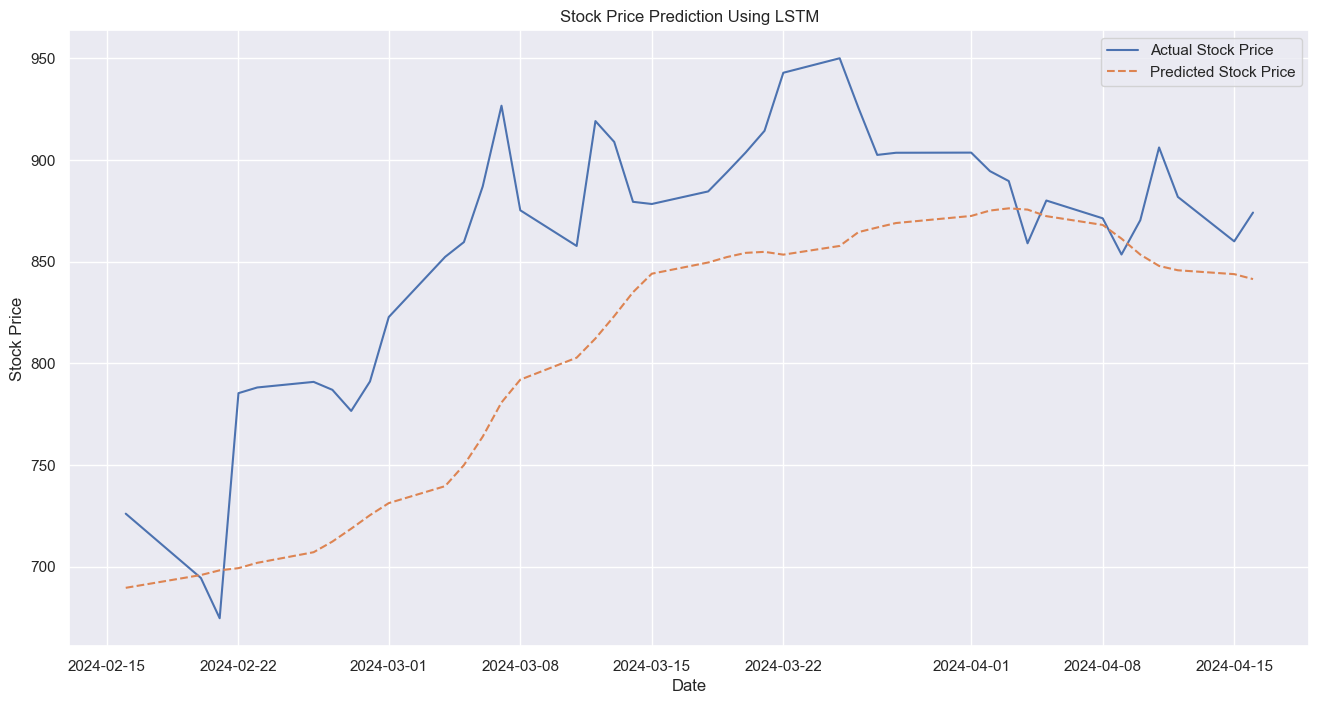

In [7]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

#Evaluate the model 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_close[-len(predictions):]['Close'], predictions)
print(f'Mean Squared Error: {mse}')

#Plot the prediction
plt.figure(figsize=(16,8))
plt.plot(df_close.index[-len(predictions):], df_close[-len(predictions):]['Close'], label='Actual Stock Price')
plt.plot(df_close.index[-len(predictions):], predictions, label='Predicted Stock Price', linestyle = 'dashed')
plt.title('Stock Price Prediction Using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

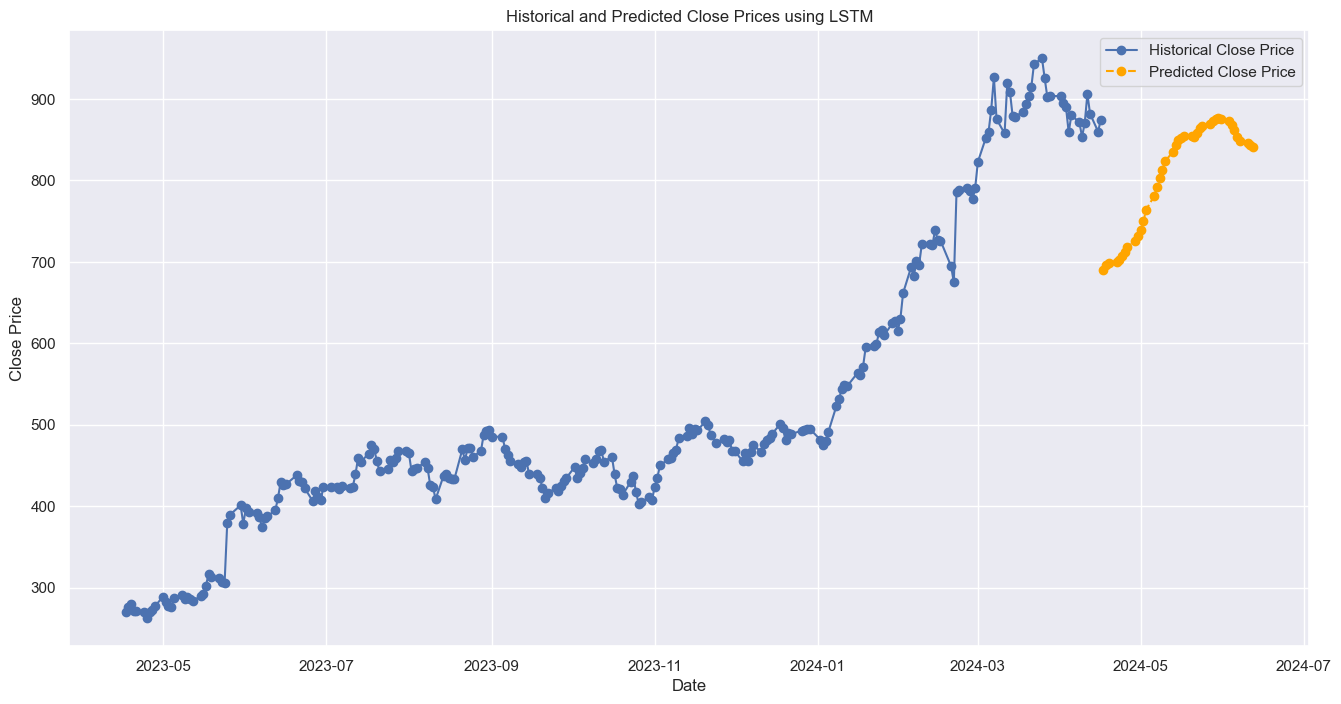

In [8]:
#Update column name used for Close Prices
Close_price_column = 'Close'

#Plot the historical close prices
plt.figure(figsize= (16, 8))
plt.plot(df_close.index, df_close[Close_price_column], label= 'Historical Close Price', marker= 'o', linestyle= '-', color = 'b')

#Plot the predicted close prices
predicted_dates = pd.date_range(start = df_close.index[-1], periods= len(predictions) + 1, freq = 'B')[1:]
plt.plot(predicted_dates, predictions, label= 'Predicted Close Price', marker= 'o', linestyle= 'dashed', color = 'orange')

plt.title('Historical and Predicted Close Prices using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()